In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable

from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances,\
                                     jensen_shannon_divergence, sample_pclouds_distances

from general_tools.strings import trim_content_after_last_dot

from general_tools.plotting import stack_images_in_square_grid

from tf_lab.nips.helper import pclouds_centered_and_half_sphere
import scipy.stats as stats

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
seed = 42
np.random.seed(seed)
save_figs = False
class_name = 'chair'

cmp_in_sphere = False
cmp_with_noise = False
cmp_jsd = False
normalize_data = True
voxel_resolution = 32

In [5]:
# Load Ground-Truth Data
in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/gt_all_' + class_name + '.npz'
gt_data = np.load(in_f)
gt_data = gt_data[gt_data.keys()[0]]

if normalize_data:
    gt_data = pclouds_centered_and_half_sphere(gt_data)

if cmp_jsd:
    _, gt_grid_var = entropy_of_occupancy_grid(gt_data, voxel_resolution, in_sphere=cmp_in_sphere)


# JSD Measurements

In [6]:
# Compare JSD of GT with random noise.
if cmp_jsd and cmp_with_noise:
    mu, sigma = 0, 1    
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    size = (len(gt_data), n_pc_samples, 3)
    random_pcs = X.rvs(np.prod(size))
    random_pcs = random_pcs.reshape(size)
    
#     lower = -0.5
#     upper = 0.5
#     random_pcs = np.random.uniform(low=lower, high=upper, size=(len(gt_data), n_pc_samples, 3))

    _, random_grid_var = entropy_of_occupancy_grid(random_pcs, voxel_resolution, in_sphere=cmp_in_sphere)
    print jensen_shannon_divergence(random_grid_var, gt_grid_var)

In [17]:
# Compare JSD of GT with synthetic data.

# exp_name = 'ae_trained_200eps_512gen_ae_emd_1c_gan_chair_2048_pts_epoch_9'
# exp_name= 'v0_raw_gan_chair_2048_pts_epoch_30'
# in_f = osp.join('/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/', exp_name + '.npz')
in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/mit_3dgan_synthetic_samples/point_clouds/2048/2K_models_per_class/chair_no_pruned.npz'


syn_data = np.load(in_f)
syn_data = syn_data[syn_data.keys()[0]]

if normalize_data:
    syn_data = pclouds_centered_and_half_sphere(syn_data)

if cmp_jsd:
    _, syn_grid_var = entropy_of_occupancy_grid(syn_data, voxel_resolution, in_sphere=cmp_in_sphere)
    print jensen_shannon_divergence(syn_grid_var, gt_grid_var)

In [112]:
class_prob = np.load('/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/nips/point_net/chair_probs_on_raw_gan.npz')
class_prob = class_prob[class_prob.keys()[0]]
class_prob = np.hstack(class_prob)

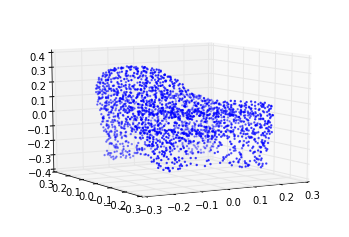

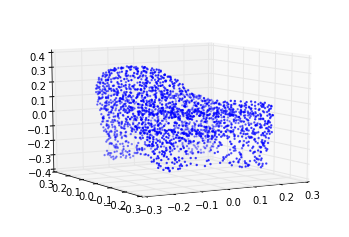

In [109]:
# cp = np.zeros(len(syn_data))
# cp[:len(class_prob)] = class_prob

cp[6]
Point_Cloud(syn_data[5]).plot()


# Pairwise Distances

0.00810811


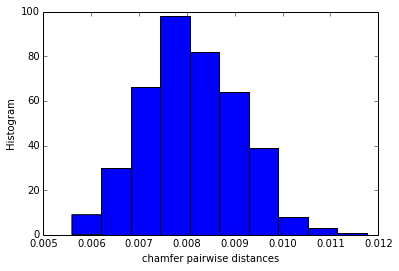

In [18]:
# check_data = syn_data[cp > 0.95]
# check_data = syn_data[:200]

check_data = syn_data
distance_type = 'chamfer'
all_dists = sample_pclouds_distances(check_data, 30, 400, distance_type)

print np.mean(all_dists)

plt.hist(all_dists)[2]
plt.xlabel(distance_type + ' pairwise distances')
plt.ylabel('Histogram')

# if save_figs:
#     if check_data == gt_data:
#         tag = 'gt_' + distance_type
#     else:
#         tag = trim_content_after_last_dot(in_f) + '_' + distance_type
                
#     plt.savefig(tag + '_dist_hist.png')

In [13]:
# np.sum(all_dists > 0.014)
all_dists

[0.0029245191,
 0.0027783217,
 0.0025632149,
 0.0026461482,
 0.0028489328,
 0.0026697558,
 0.0027299966,
 0.0023462768,
 0.0024729813,
 0.0029718613,
 0.003022271,
 0.0026489408,
 0.0030002599,
 0.0025515396,
 0.0031113231,
 0.0030001651,
 0.0030551492,
 0.0027074816,
 0.0027563348,
 0.0026085102,
 0.0029162595,
 0.0028296381,
 0.0025974549,
 0.0028225412,
 0.0031167816,
 0.0028781104,
 0.0027254433,
 0.002526927,
 0.0030498691,
 0.0029562367,
 0.0029561357,
 0.0029167249,
 0.0024907454,
 0.0025757798,
 0.0029787433,
 0.0030375856,
 0.0024250848,
 0.0025320041,
 0.0026281145,
 0.0027233374,
 0.0026966194,
 0.0028948537,
 0.0032265708,
 0.0028373301,
 0.003263101,
 0.0026772229,
 0.0030713915,
 0.0024993778,
 0.0025041795,
 0.0030004466,
 0.0031122919,
 0.0029477128,
 0.0029231941,
 0.0028495991,
 0.0031129245,
 0.0030770176,
 0.0025285059,
 0.0028237703,
 0.0028122216,
 0.003069777,
 0.002601807,
 0.0026727091,
 0.0029749805,
 0.0024965466,
 0.0027760617,
 0.0028631282,
 0.0026625847,


# Plotting data in grid

In [19]:
top_fig_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/Images/'
top_fig_dir = create_dir(osp.join(top_fig_dir, exp_name))

size = 500
rids = np.random.choice(range(len(syn_data)), size=size, replace=False)
plt.ioff()

for i in range(size):
    fig = Point_Cloud(syn_data[rids[i]]).plot(show=False, show_axis=False, azim=290, in_u_sphere=True, s=20);
    fig.savefig(osp.join(top_fig_dir, 'sample_' +str(i)))
    plt.close()

file_names = glob.glob(top_fig_dir +'/*.png')
stack_images_in_square_grid(file_names, save_file= osp.join(top_fig_dir, 'aggregate_samples.png'))

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


<PIL.Image.Image image mode=RGB size=13200x8800 at 0x7F848C0B1CF8>